In [198]:
import itertools
import math
import random
import requests
from pydantic import BaseModel, constr
from typing import Optional, List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from scipy.spatial import KDTree
import geopandas as gpd
from shapely.geometry import Point
from IPython.display import display
from matplotlib.ticker import MultipleLocator

%config InlineBackend. figure_format = 'retina'
sns.set()

BASE_URL = 'https://sherlock.aerobotics.com/developers'
token_path = 'api_token.txt'
with open(token_path, 'r', encoding='utf-8') as file:
    API_TOKEN = file.read()
orchid_id = 216269

In [199]:
class TreeSurvey(BaseModel):
    id: int
    survey_id: int
    latitude: float
    longitude: float
    radius: float
    ndre: float
    ndvi: float
    height: float
    area: float

class Survey(BaseModel):
    id: int
    hectares: float
    orchard_id: int
    date: str  # Assuming date is in a string format like 'YYYY-MM-DD'
    upload_id: int

class Orchard(BaseModel):
    id: int
    hectares: float
    name: constr(min_length=1, max_length=40)
    farm_id: int
    client_id: int
    polygon: str  # Assuming this is a string representation of the polygon data
    crop_type: constr(min_length=1)

class TreeSurveyResponse(BaseModel):
    count: int
    next: Optional[constr(min_length=1)]
    previous: Optional[constr(min_length=1)]
    results: List[TreeSurvey]

In [267]:

def get_treesurvey(orchard_id: str, api_token: str) -> TreeSurveyResponse:
    url = f"{BASE_URL}/treesurveys/?survey__orchard_id={orchard_id}"
    headers = {
        "accept": "application/json",
        "Authorization": api_token,
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        try:
            return TreeSurveyResponse.model_validate(response.json())
        except Exception as e:
            raise ValueError(f"Failed to parse response data: {e}")
    else:
        response.raise_for_status()

# Example usage
try:
    orchard_id = "216269"
    result = get_treesurvey(orchard_id, API_TOKEN)
    print(result)
except Exception as e:
    print(f"Error: {e}")


count=508 next=None previous=None results=[TreeSurvey(id=54733434, survey_id=25319, latitude=-32.3279643, longitude=18.826872, radius=2.0, ndre=0.557, ndvi=0.872, height=3.25, area=22.667), TreeSurvey(id=54733276, survey_id=25319, latitude=-32.3281893, longitude=18.8263421, radius=2.0, ndre=0.559, ndvi=0.881, height=2.422, area=22.662), TreeSurvey(id=54733233, survey_id=25319, latitude=-32.3283205, longitude=18.8256169, radius=2.0, ndre=0.57, ndvi=0.888, height=2.949, area=25.908), TreeSurvey(id=54733009, survey_id=25319, latitude=-32.3287595, longitude=18.8262246, radius=2.0, ndre=0.499, ndvi=0.84, height=2.382, area=16.451), TreeSurvey(id=54733324, survey_id=25319, latitude=-32.3280753, longitude=18.8255473, radius=2.0, ndre=0.555, ndvi=0.869, height=3.178, area=25.914), TreeSurvey(id=54733279, survey_id=25319, latitude=-32.3280162, longitude=18.8263217, radius=2.0, ndre=0.572, ndvi=0.884, height=2.242, area=22.037), TreeSurvey(id=54733259, survey_id=25319, latitude=-32.3279874, long

In [201]:
def treesurvey_to_dataframe(treesurvey_response: TreeSurveyResponse) -> pd.DataFrame:
    data = [treesurvey.model_dump() for treesurvey in treesurvey_response.results]
    df = pd.DataFrame(data)
    return df

In [202]:
df = treesurvey_to_dataframe(result)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))
gdf.to_crs(gdf.estimate_utm_crs(), inplace=True)

,id,survey_id,latitude,longitude,radius,ndre,ndvi,height,area,geometry
0,54733434,25319,-32.327964,18.826872,2.0,0.557,0.872,3.250,22.667,POINT (295449.295 6421135.967)
1,54733276,25319,-32.328189,18.826342,2.0,0.559,0.881,2.422,22.662,POINT (295399.913 6421110.006)
2,54733233,25319,-32.328320,18.825617,2.0,0.570,0.888,2.949,25.908,POINT (295331.933 6421094.072)
3,54733009,25319,-32.328759,18.826225,2.0,0.499,0.840,2.382,16.451,POINT (295390.134 6421046.556)
4,54733324,25319,-32.328075,18.825547,2.0,0.555,0.869,3.178,25.914,POINT (295324.828 6421121.127)
...,...,...,...,...,...,...,...,...,...,...
503,54733043,25319,-32.328779,18.826644,2.0,0.484,0.817,2.424,11.123,POINT (295429.700 6421045.196)
504,54733370,25319,-32.327872,18.826154,2.0,0.564,0.876,2.707,19.976,POINT (295381.452 6421144.829)
505,54732982,25319,-32.328519,18.825960,2.0,0.560,0.876,3.276,23.513,POINT (295364.644 6421072.728)
506,54733352,25319,-32.327738,18.826340,2.0,0.569,0.887,2.647,26.120,POINT (295398.737 6421160.055)


<Axes: >

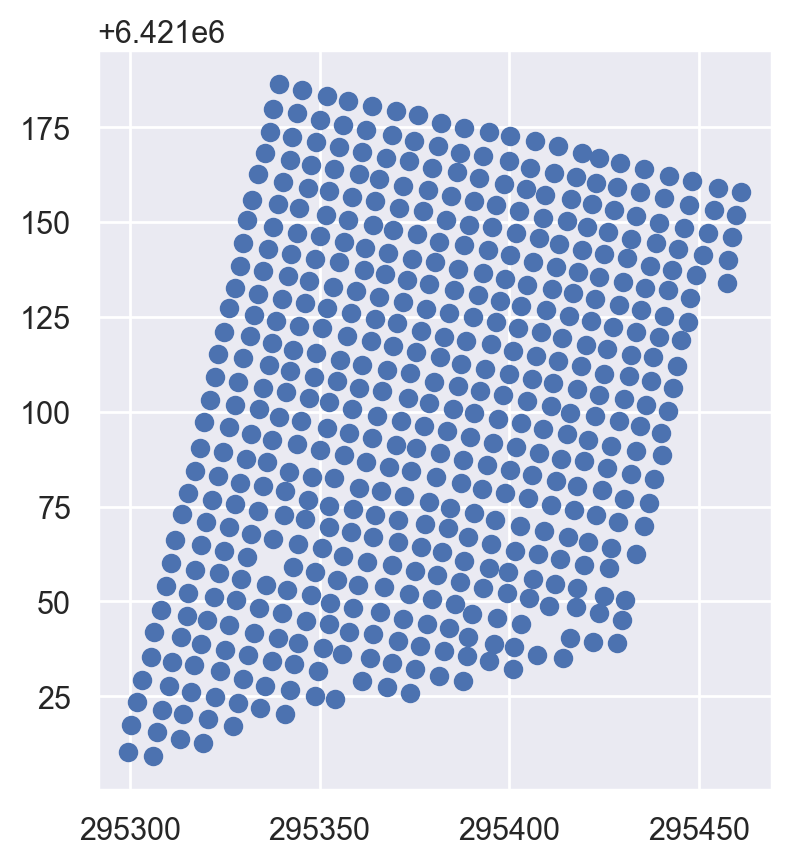

In [204]:
display(gdf)
gdf.plot()

Nearest neighbors (Scikit-Learn): [[  0 142]
 [  1 492]
 [  2 221]
 ...
 [505 499]
 [506 460]
 [507 347]]


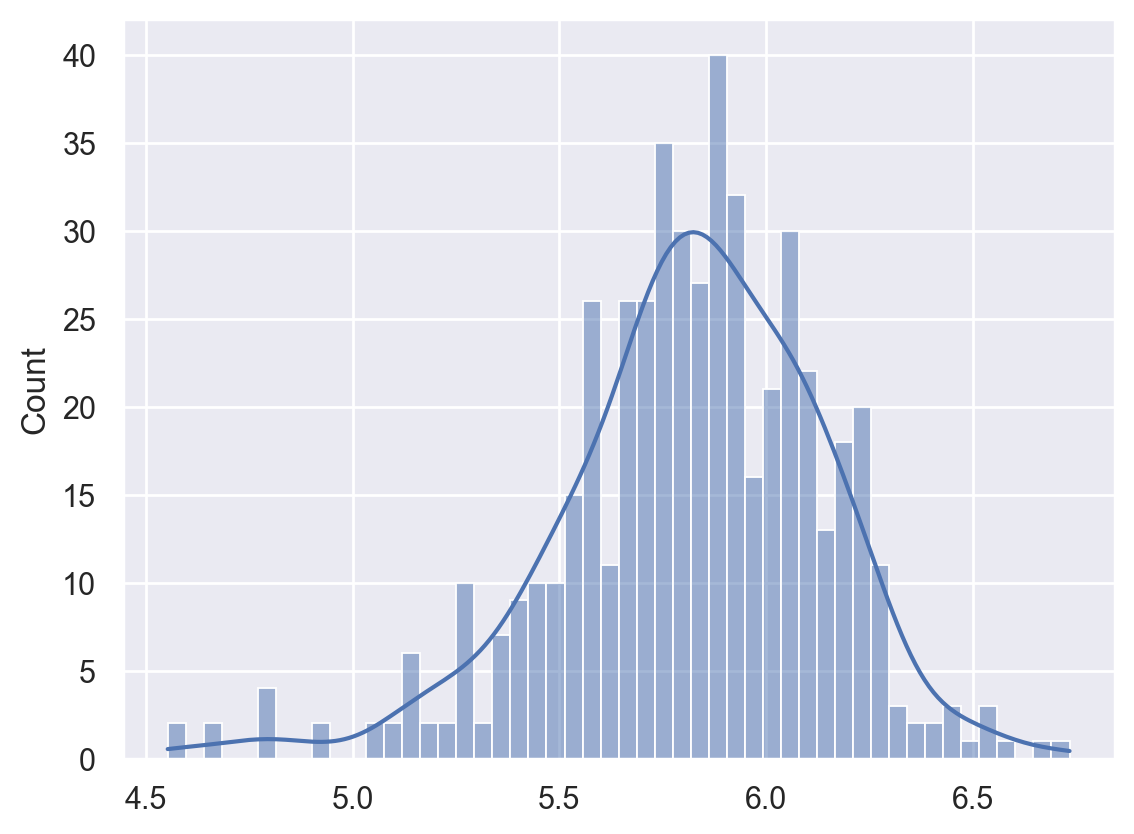

In [205]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Example array of points
points = np.column_stack((gdf.geometry.y, gdf.geometry.x))

# Using NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(points)
distances, indices = nbrs.kneighbors(points)

# indices[:, 1] contains the indices of the nearest neighbors
print("Nearest neighbors (Scikit-Learn):", indices)
sns.histplot(distances[:,1], bins=50, kde='density')
plt.show()

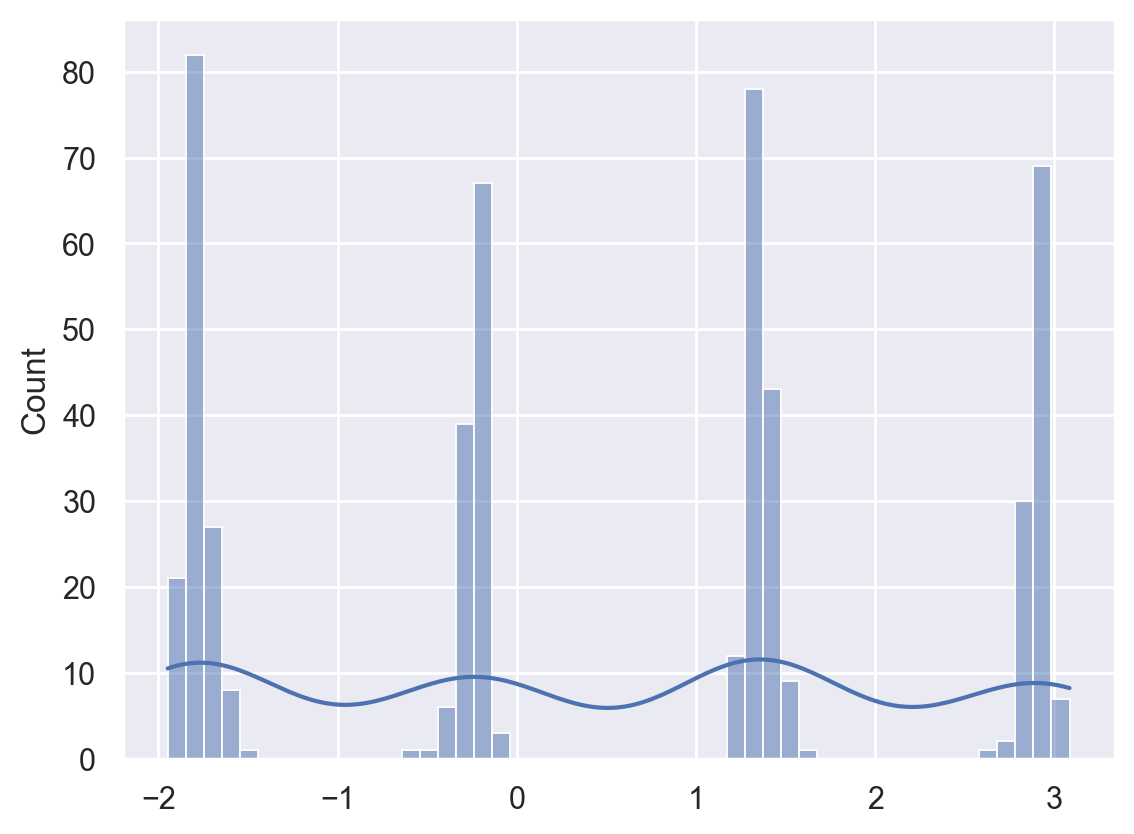

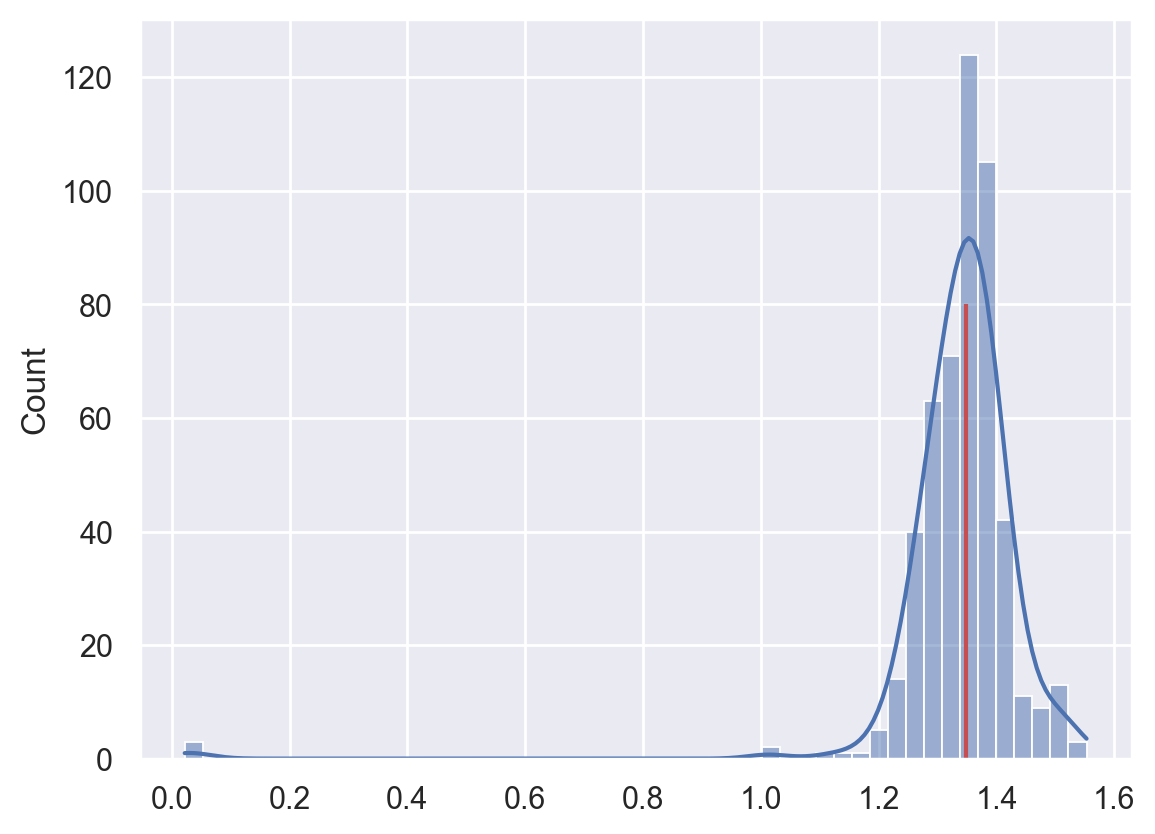

In [206]:
delta = np.subtract(points[indices[:,0]], points[indices[:,1]])
angles = np.arctan2(delta[:,0], delta[:,1])
sns.histplot(angles, bins=50, kde='density')
plt.show()
angles %= (np.pi/2)
sns.histplot(angles, bins=50, kde='density')
plt.vlines(np.median(angles), 0, 80, colors='r')
plt.show()

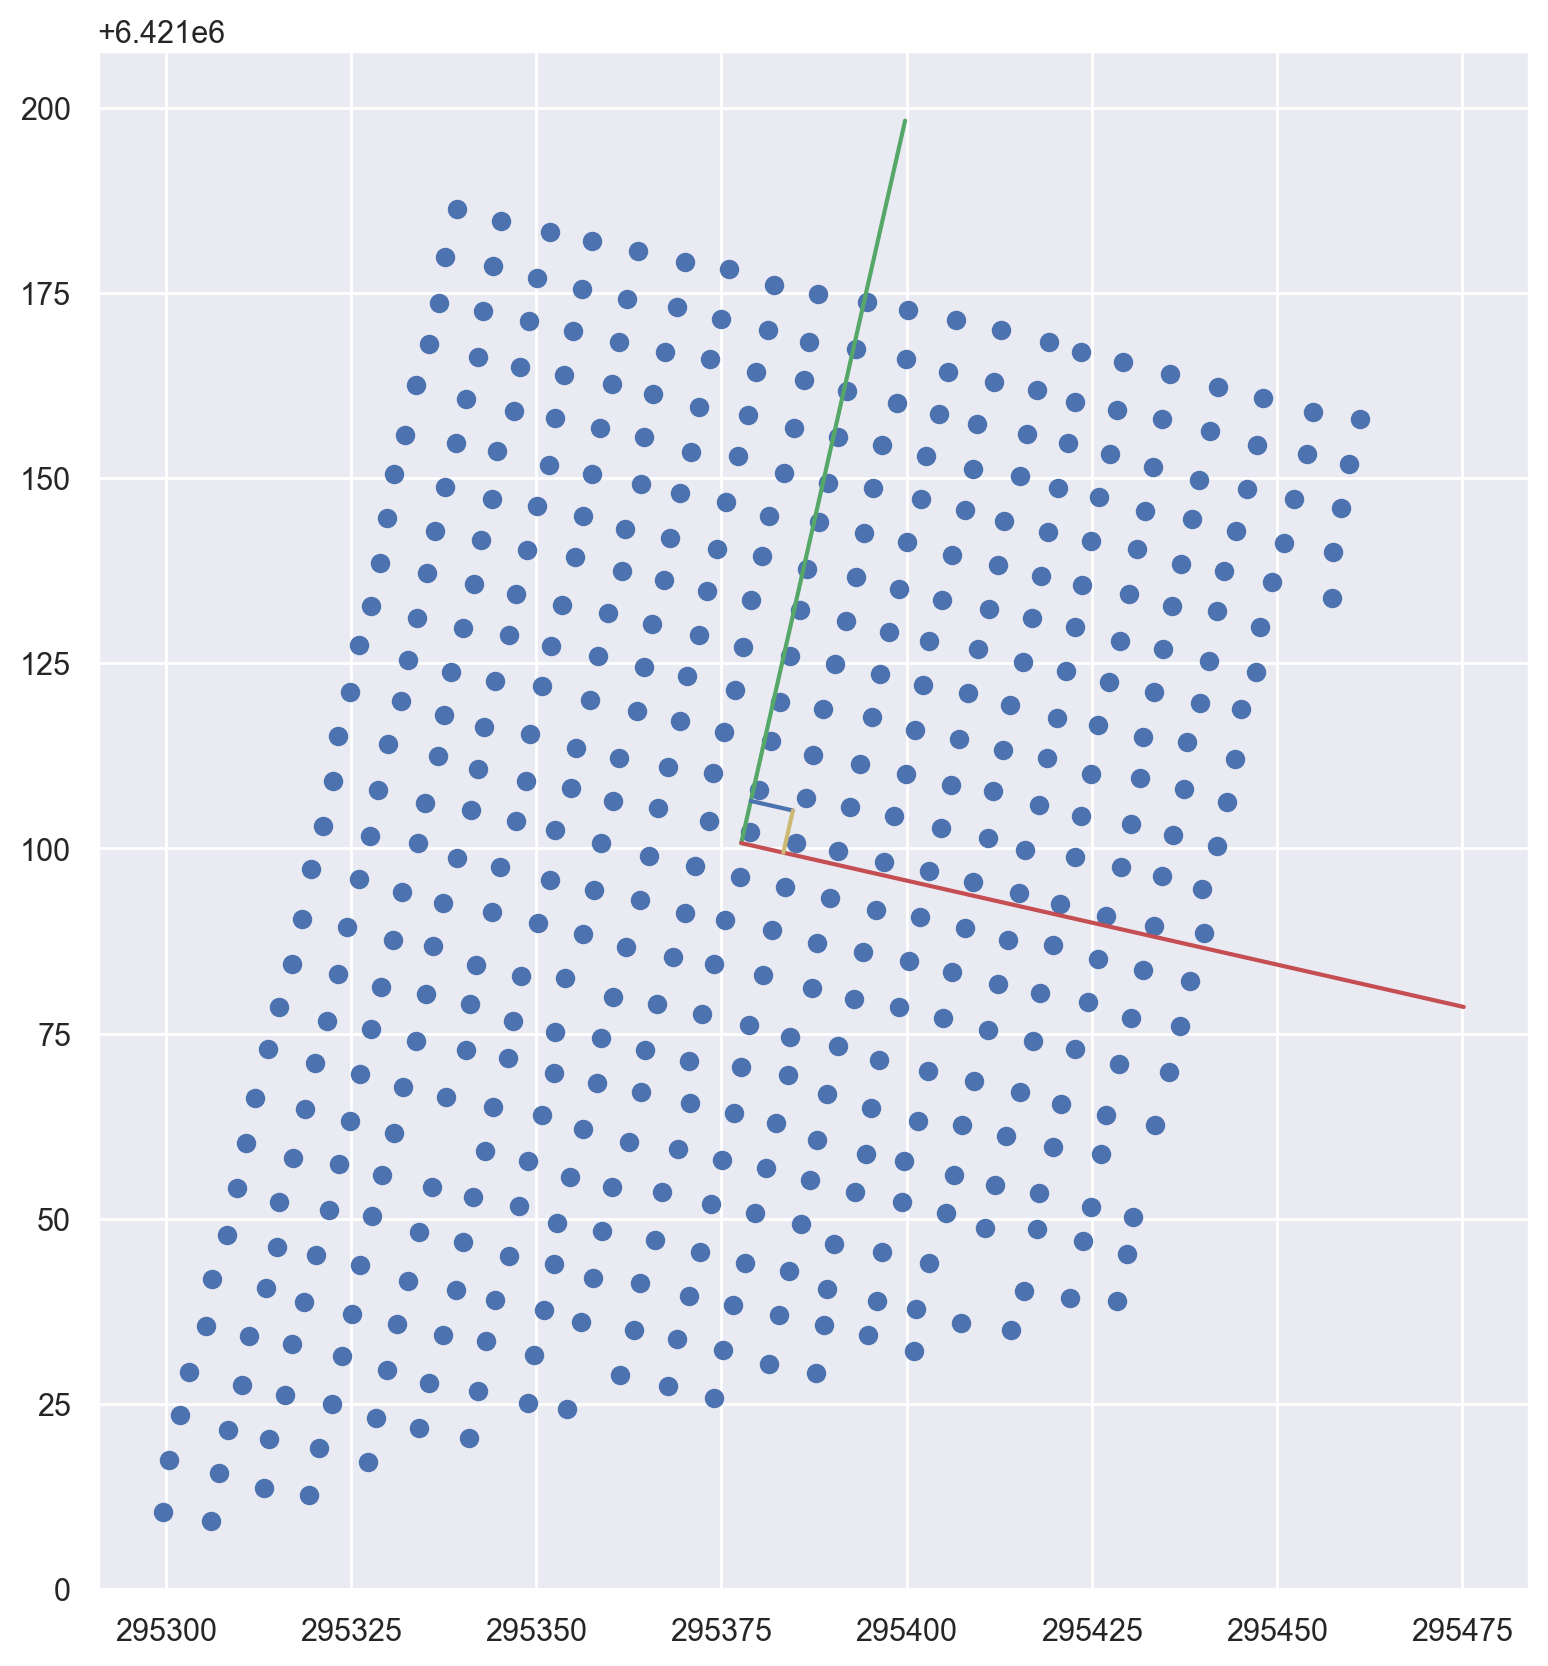

In [224]:
cy, cx = np.mean(points, axis=0)
d = np.median(distances[:,1])
a = np.median(angles)
b = a - (np.pi/2)


fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal', 'box')
gdf.plot(ax=ax)
ax.plot([cx, cx+100*np.cos(a)], [cy, cy+100*np.sin(a)], c='g')
ax.plot([cx, cx+100*np.cos(b)], [cy, cy+100*np.sin(b)], c='r')
ax.plot([cx+d*np.cos(a), cx+d*(np.cos(a)+np.cos(b))], [cy+d*np.sin(a), cy+d*(np.sin(a)+np.sin(b))], c='b')
ax.plot([cx+d*np.cos(b), cx+d*(np.cos(a)+np.cos(b))], [cy+d*np.sin(b), cy+d*(np.sin(a)+np.sin(b))], c='y')


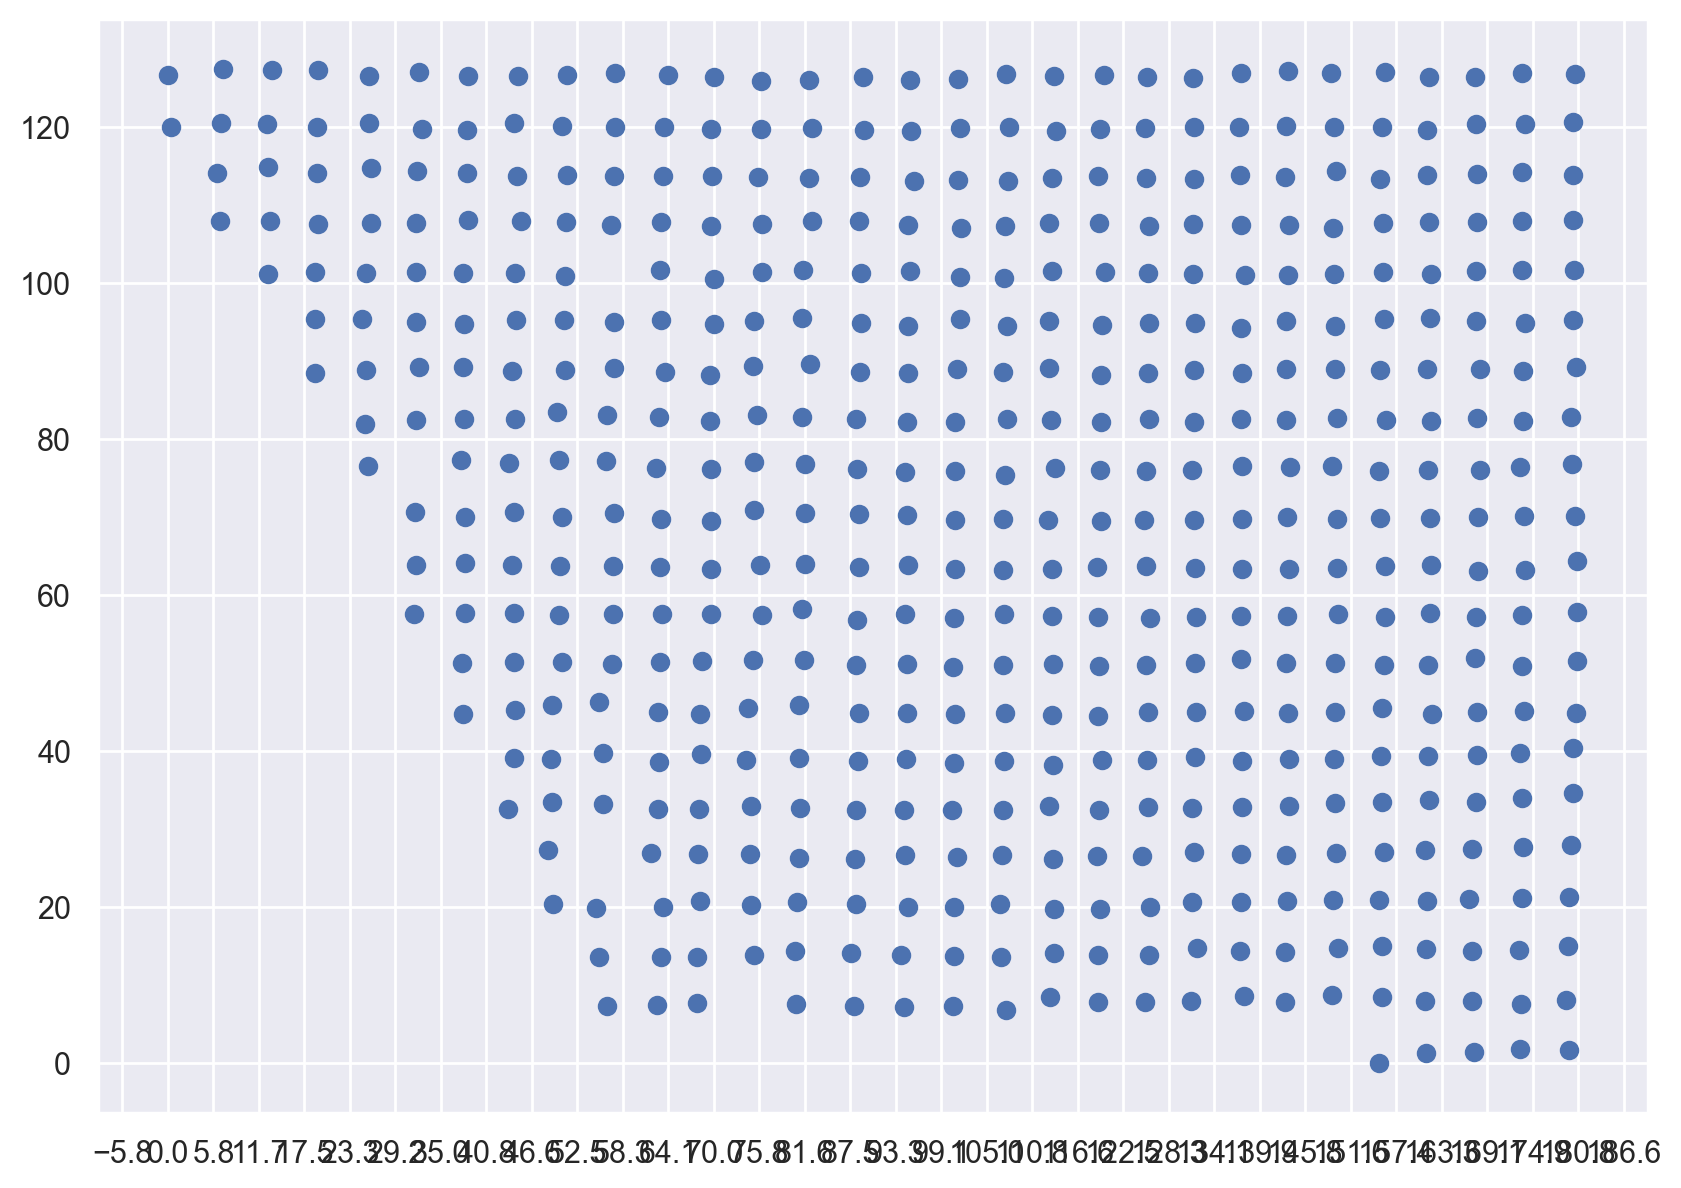

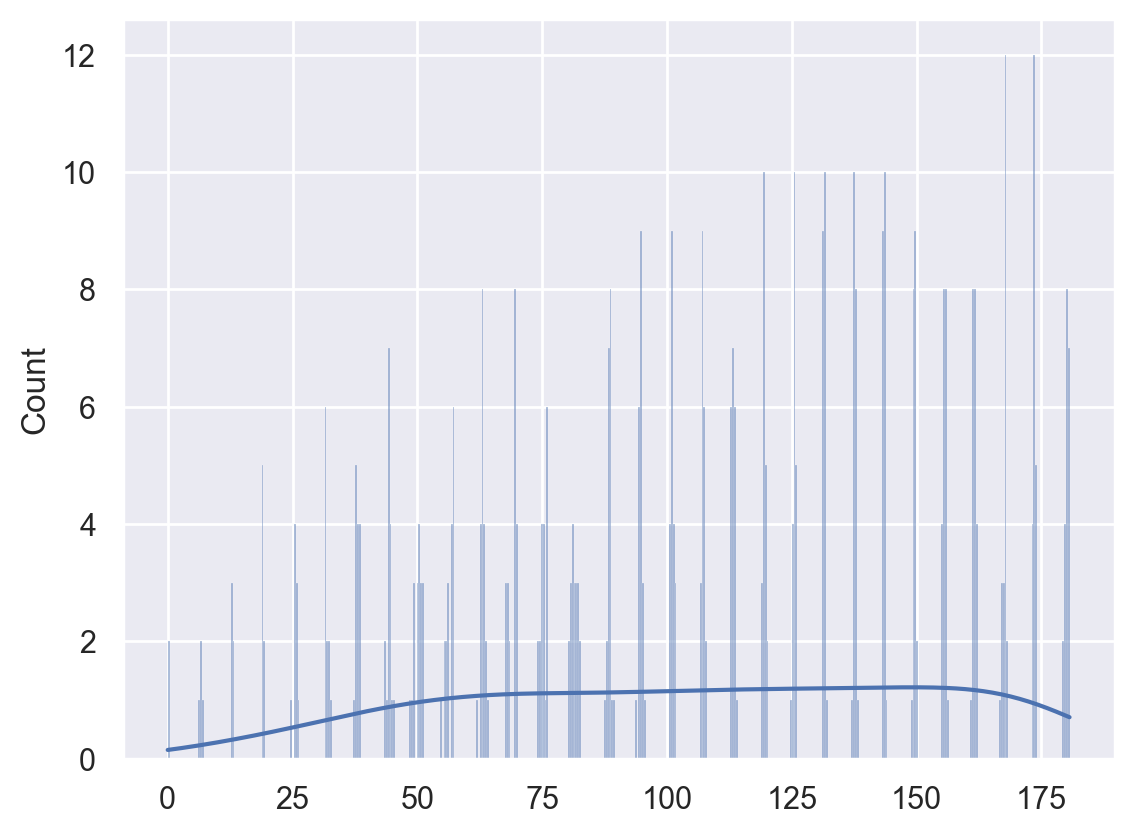

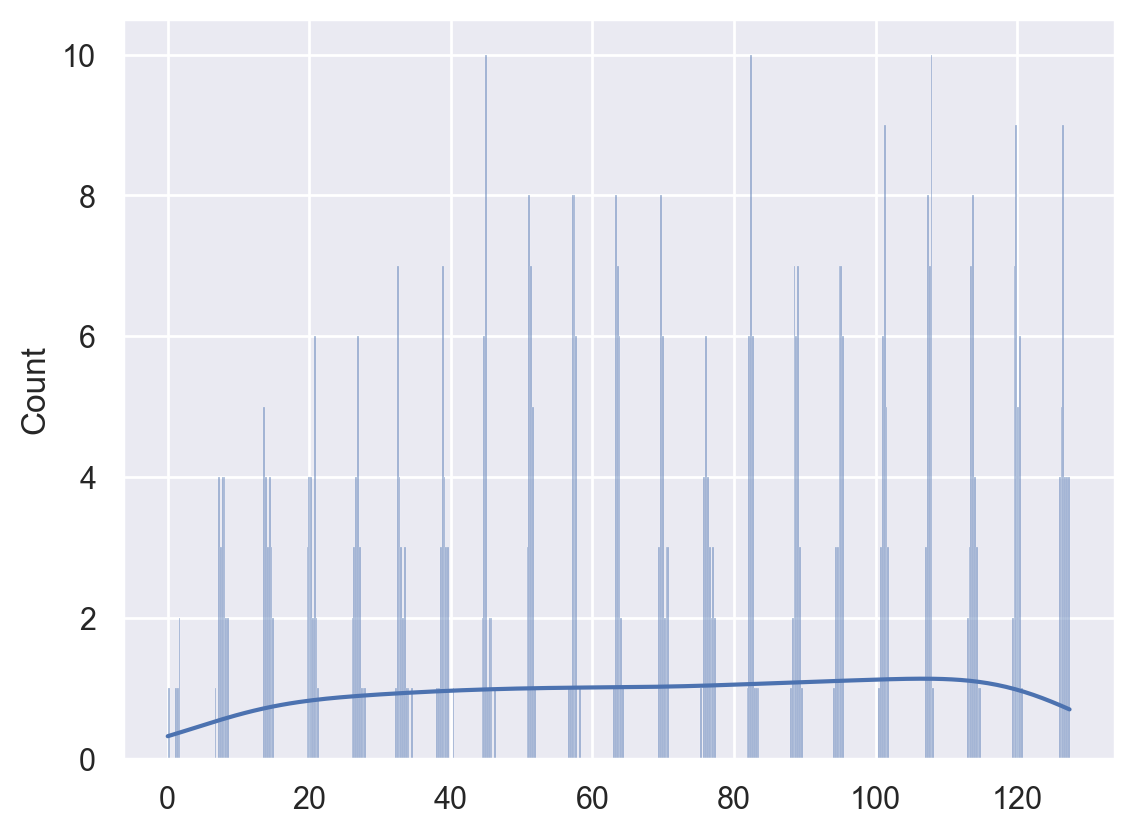

In [225]:
c, s = np.cos(a), np.sin(a)
R = np.array([[c, -s],
              [s, c]])
centred_points = points - np.array([cy,cx])
normalised_points = (R @ centred_points.T).T
normalised_points -= np.min(normalised_points, axis=0)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal', 'box')
plt.scatter(x=normalised_points[:,1], y=normalised_points[:,0])
plt.gca().xaxis.set_major_locator(MultipleLocator(d))
plt.show()
sns.histplot(normalised_points[:,1], bins=500, kde='density')
plt.show()
sns.histplot(normalised_points[:,0], bins=500, kde='density')
plt.show()

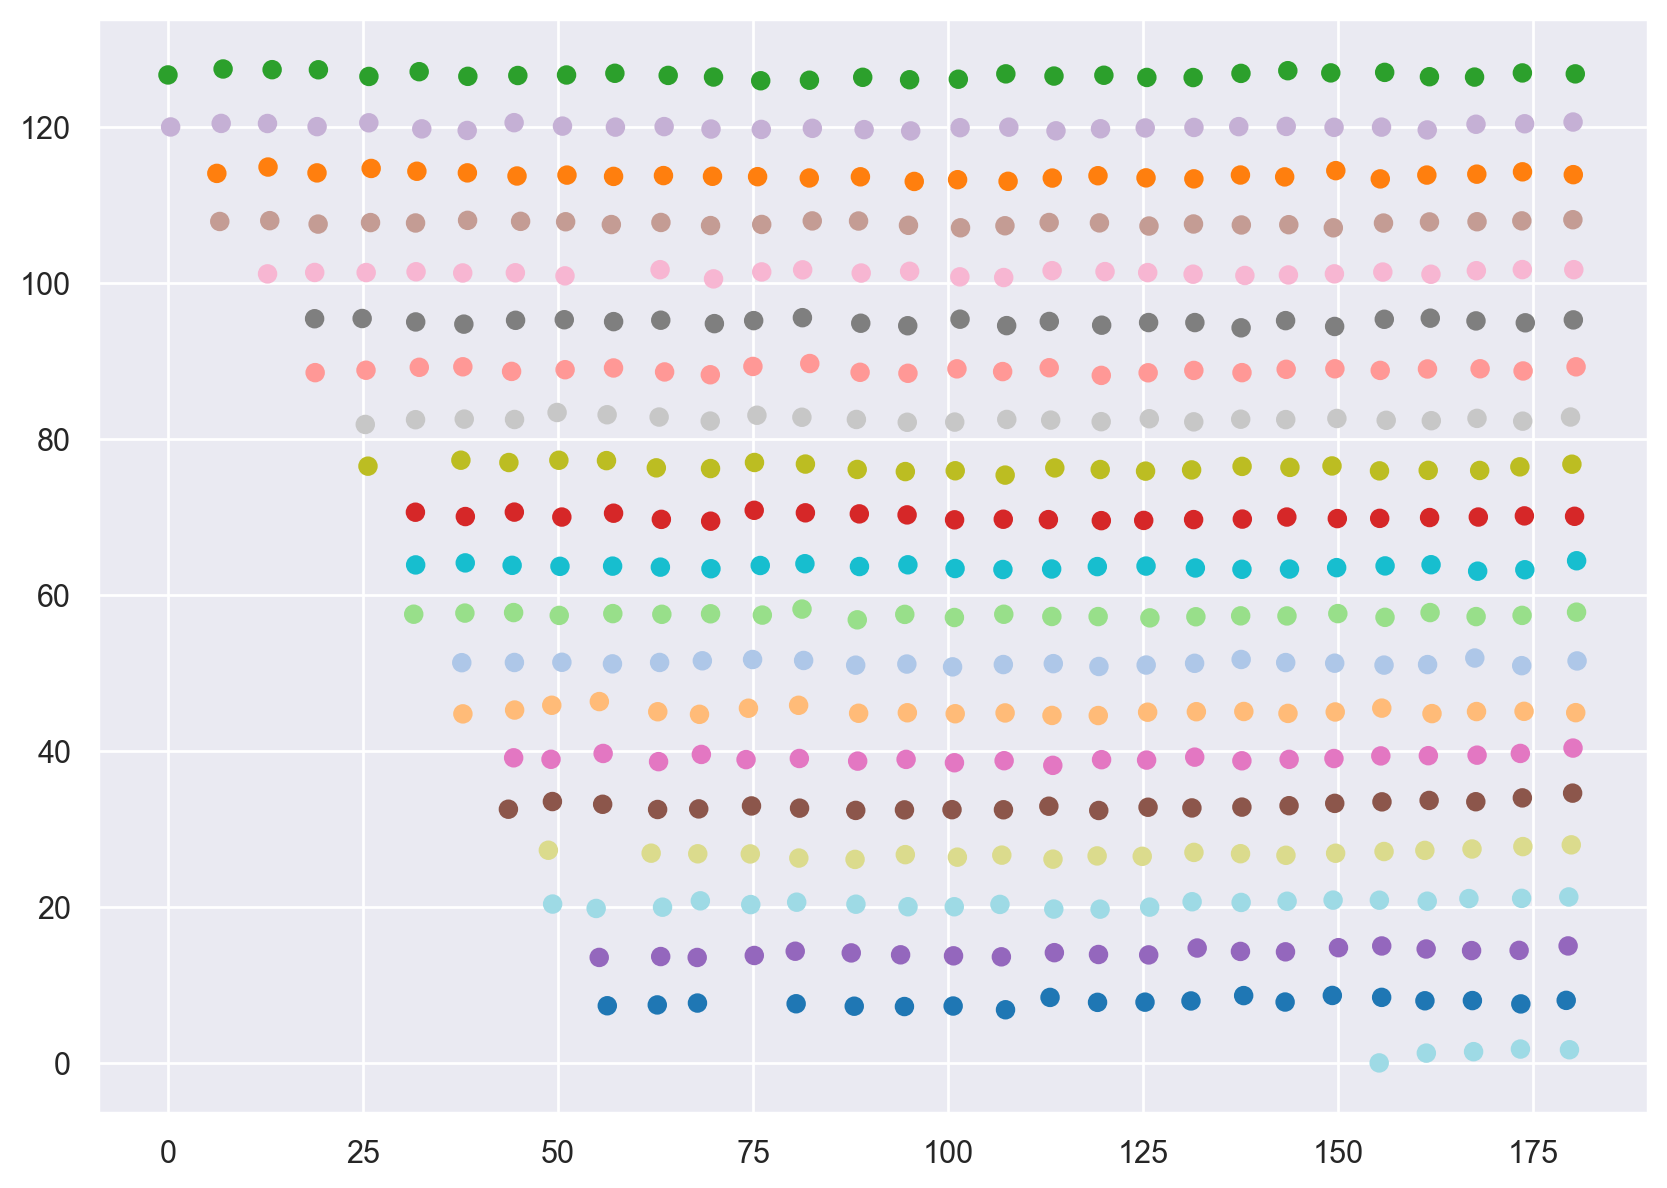

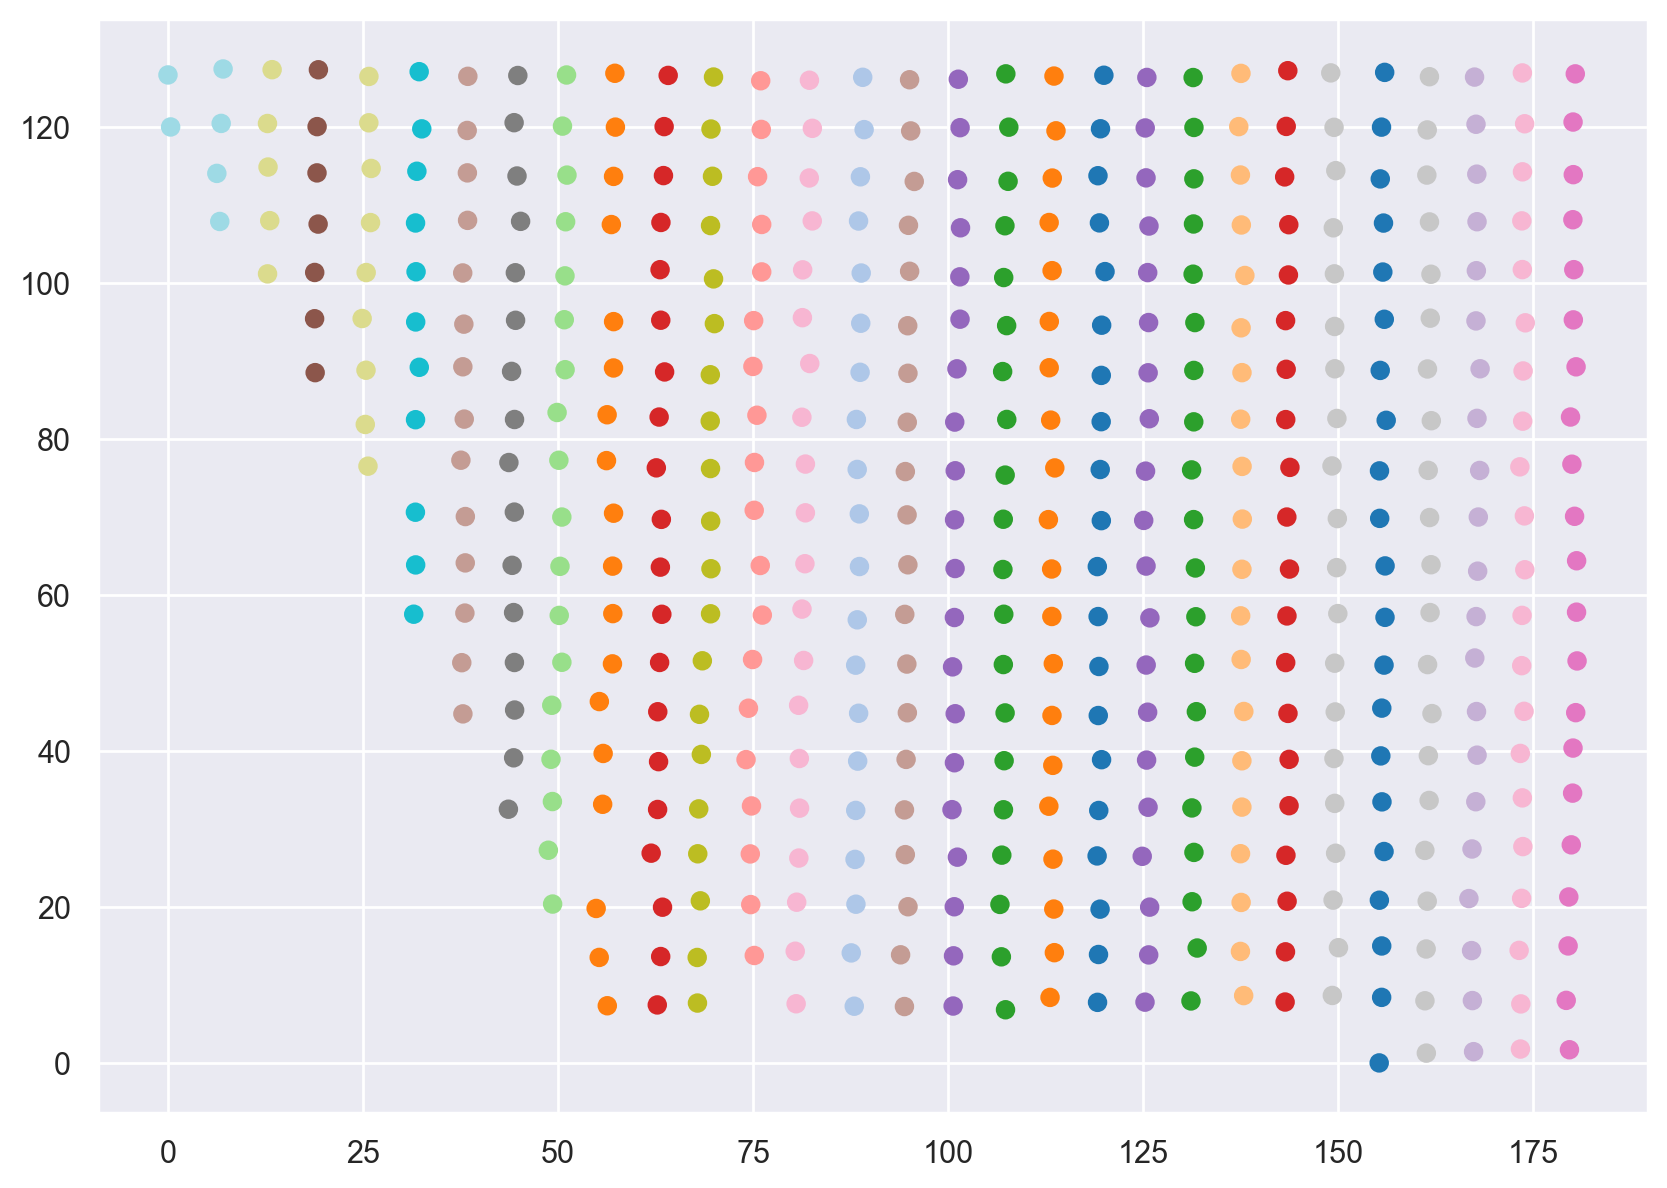

In [272]:
from sklearn.cluster import DBSCAN

eps = np.min(distances[:,1])/2
dbscan = DBSCAN(eps=eps, min_samples=2, metric='manhattan')

# Fit the model
rows = dbscan.fit(normalised_points[:,:1]).labels_
columns = dbscan.fit(normalised_points[:,-1:]).labels_


fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal', 'box')
plt.scatter(x=normalised_points[:,1], y=normalised_points[:,0], c=rows, cmap='tab20')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal', 'box')
plt.scatter(x=normalised_points[:,1], y=normalised_points[:,0], c=columns, cmap='tab20')
plt.show()

Found 26 trees


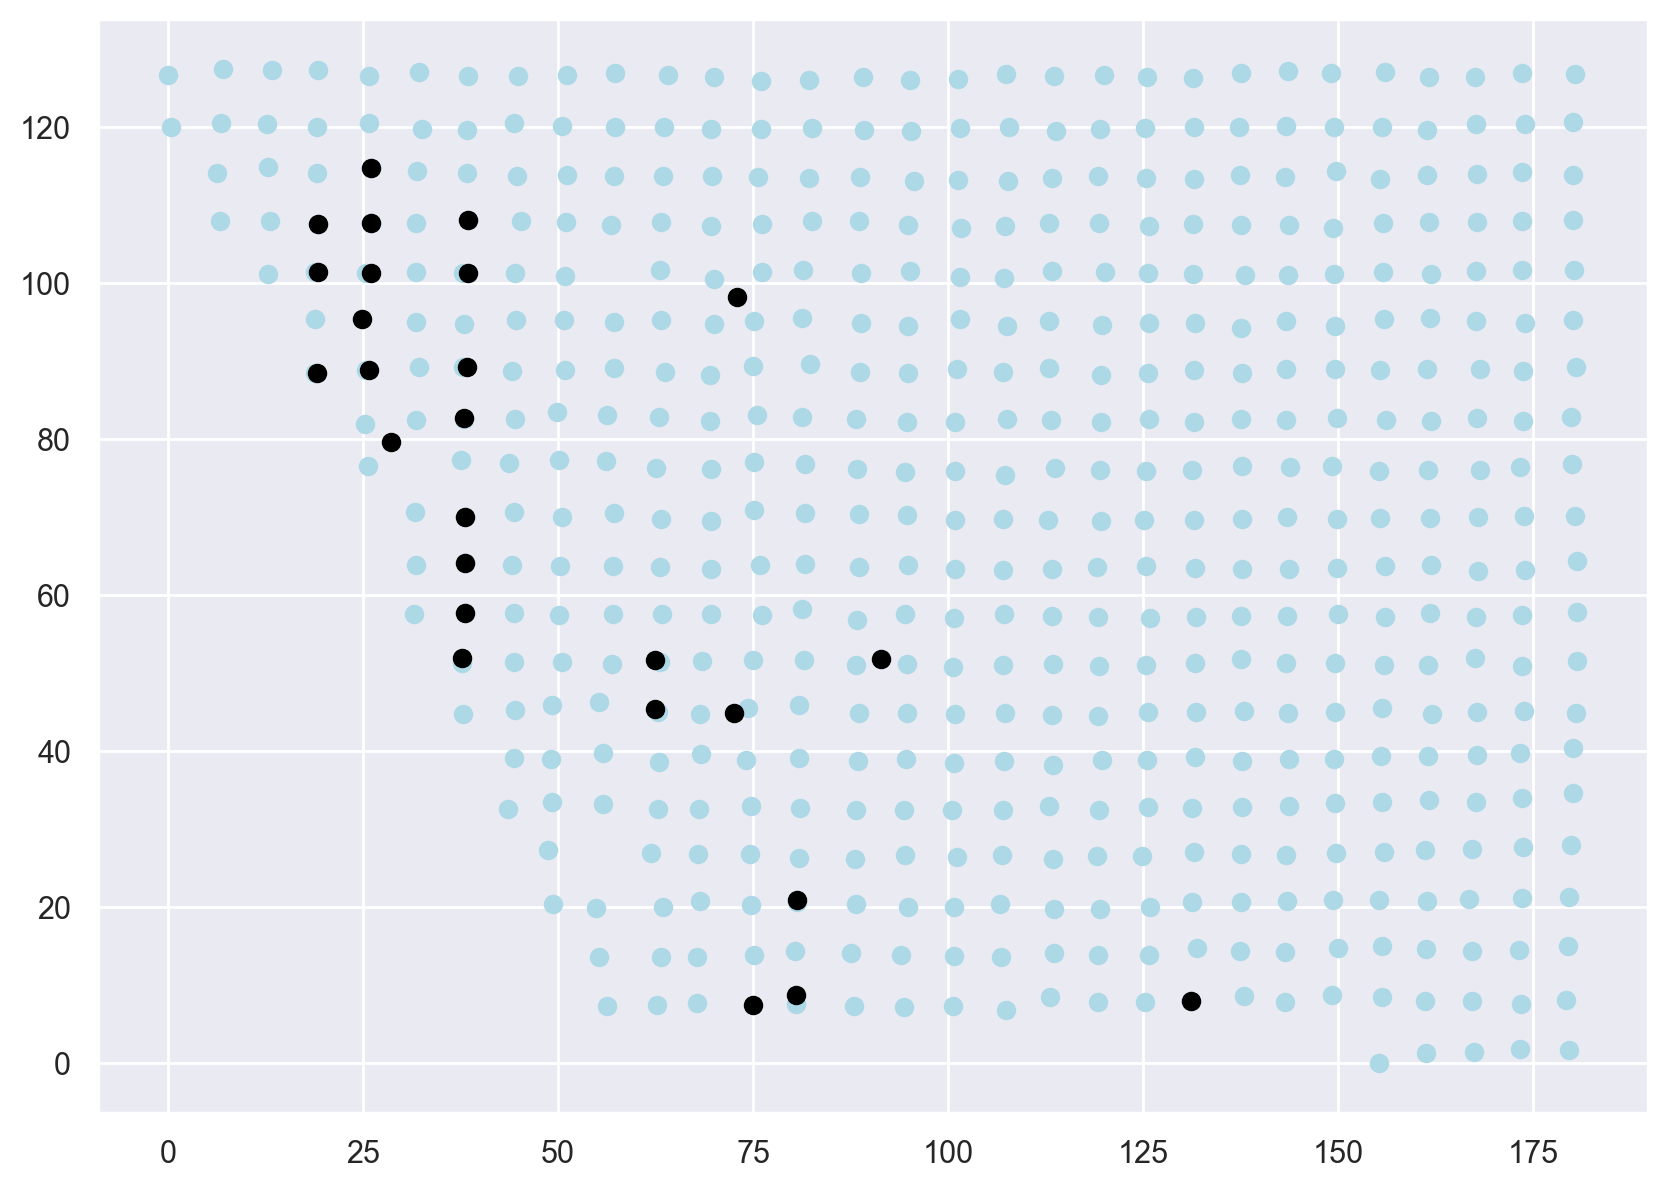

In [283]:
row_incides = np.arange(np.max(rows))
col_incides = np.arange(np.max(columns))
grid_points = {k:v for k,v in zip(zip(rows,columns), normalised_points)}
missing = []
for r in row_incides:
    for c in col_incides:
        if (r,c) not in grid_points:
            neighbours = []
            for pos in ((r-1,c), (r+1,c), (r,c-1), (r,c+1)):
                if pos in grid_points:
                    neighbours.append(grid_points[pos])
            if len(neighbours) > 2:
                missing.append(np.median(neighbours, axis=0))
missing = np.array(missing)
print(f'Found {len(missing)} trees')

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal', 'box')
plt.scatter(x=normalised_points[:,1], y=normalised_points[:,0], c='lightblue')
plt.scatter(x=missing[:,1], y=missing[:,0], c='black')

plt.show()


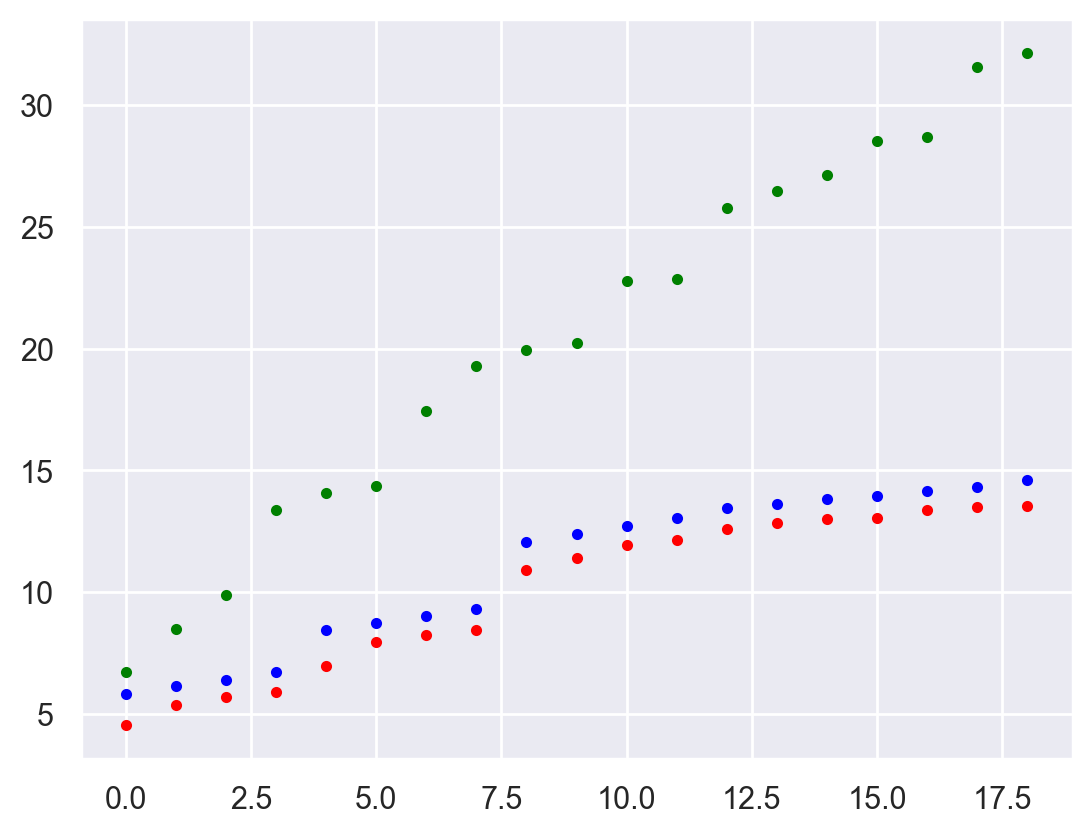

In [260]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='auto').fit(points)
distances, indices = nbrs.kneighbors(points)
plt.plot(np.min(distances[:,1:], axis=0), '.', c='red')
plt.plot(np.median(distances[:,1:], axis=0), '.', c='blue')
plt.plot(np.max(distances[:,1:], axis=0), '.', c='green')